In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func, desc

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [11]:
measurement_columns = inspector.get_columns('measurement')
for column in measurement_columns:
    print(column["name"], column["type"])
    
print()

station_columns = inspector.get_columns('station')
for column in station_columns:
    print(column["name"], column["type"])   

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [12]:
engine.execute('SELECT * FROM measurement LIMIT 5').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

In [13]:
# Find the last date with an entry
session.query(measurement.date).order_by(desc(measurement.date)).first()

('2017-08-23')

In [14]:
# Query records 1 year ago from last record entry
year_prcp = session.query(measurement.date, measurement.prcp).filter(measurement.date > '2016-08-22').order_by(measurement.date).all()

In [15]:
prcp_df = pd.DataFrame(year_prcp)
prcp_df['date'] =  pd.to_datetime(prcp_df['date'], format='%Y-%m-%d')
prcp_df.set_index('date', inplace=True)
prcp_df.head()


,prcp
date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,NaN
2016-08-23,0.02


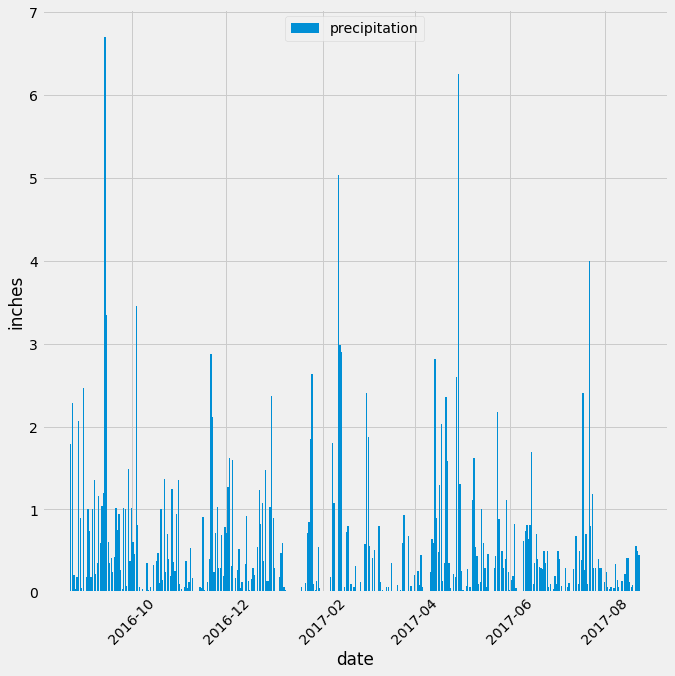

In [16]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.bar(prcp_df.index, prcp_df.prcp)
plt.xticks(rotation=45)
plt.legend(['precipitation'], loc='upper center')
plt.xlabel('date')
plt.ylabel('inches')
plt.show()

In [17]:
prcp_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [18]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from today

# Perform a query to retrieve the data and precipitation scores

# Save the query results as a Pandas DataFrame and set the index to the date column

# Sort the dataframe by date

# Use Pandas Plotting with Matplotlib to plot the data

# Rotate the xticks for the dates


![precipitation](Images/precipitation.png)

In [19]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [20]:
# How many stations are available in this dataset?
session.query(station.id).count()

9

In [21]:
# What are the most active stations?
# List the stations and the counts in descending order.

session.query(measurement.station, func.count(measurement.station))\
.group_by(measurement.station)\
.order_by(func.count(measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [22]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
tobs_avg = session.query(func.avg(measurement.tobs)).filter(measurement.station == 'USC00519281').all()
tobs_max = session.query(func.max(measurement.tobs)).filter(measurement.station == 'USC00519281').all()
tobs_min = session.query(func.min(measurement.tobs)).filter(measurement.station == 'USC00519281').all()
print(f'USC00519281 lowest temp: {tobs_min[0]}')
print(f'USC00519281 highest temp: {tobs_max[0]}')
print(f'USC00519281 average temp: {tobs_avg[0]}')

USC00519281 lowest temp: (54.0,)
USC00519281 highest temp: (85.0,)
USC00519281 average temp: (71.66378066378067,)


In [23]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
year_temp = session.query(measurement.date, measurement.tobs)\
.filter(measurement.date > '2016-08-22')\
.filter(measurement.station == 'USC00519281')\
.order_by(measurement.date).all()

year_temp_df = pd.DataFrame(year_temp)

In [24]:
year_temp_df.head()

,date,tobs
0,2016-08-23,77.0
1,2016-08-24,77.0
2,2016-08-25,80.0
3,2016-08-26,80.0
4,2016-08-27,75.0


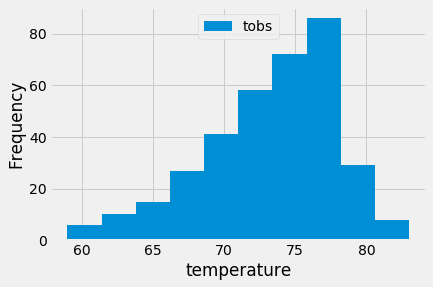

In [25]:
year_temp_df.head()
plt.hist(year_temp_df.tobs)
plt.legend(['tobs'], loc='upper center')
plt.xlabel('temperature')
plt.ylabel('Frequency')
plt.show()

In [26]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)).\
        filter(measurement.date >= start_date).filter(measurement.date <= end_date).all()
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [27]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
print(calc_temps('2011-02-28','2011-03-05'))

[(61.0, 69.75510204081633, 75.0)]


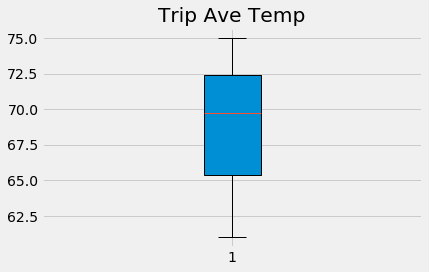

In [28]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

fig, ax = plt.subplots()
ax.boxplot(calc_temps('2011-02-28','2011-03-05'), patch_artist=True)
ax.set_title('Trip Ave Temp')
fig.tight_layout()
plt.show()

In [29]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
session.query(measurement.station, func.sum(measurement.prcp), station.name, 
              station.latitude, station.longitude, station.elevation)\
.filter(measurement.date > '2016-08-22')\
.group_by(measurement.station)\
.order_by(func.sum(measurement.prcp).desc()).all()


[('USC00516128',
  1330.2899999999968,
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4),
 ('USC00519281',
  630.2699999999984,
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4),
 ('USC00513117',
  436.5899999999951,
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4),
 ('USC00519523',
  342.0899999999993,
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4),
 ('USC00514830',
  299.15999999999997,
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4),
 ('USC00519397',
  144.81000000000117,
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4),
 ('USC00517948',
  41.30999999999996,
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4)]

In [30]:
session.query(measurement.station, func.sum(measurement.prcp), station.name,station.latitude, 
              station.longitude, station.elevation)\
.filter(measurement.date > '2016-08-22')\
.filter(measurement.station == station.station)\
.group_by(station.id)\
.order_by(func.sum(measurement.prcp).desc()).all()

[('USC00516128',
  147.81000000000006,
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4),
 ('USC00519281',
  70.03000000000003,
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9),
 ('USC00513117',
  48.510000000000026,
  'KANEOHE 838.1, HI US',
  21.4234,
  -157.8015,
  14.6),
 ('USC00519523',
  38.01,
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5),
 ('USC00514830',
  33.239999999999995,
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0),
 ('USC00519397',
  16.089999999999986,
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0),
 ('USC00517948', 4.59, 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9)]

## Optional Challenge Assignment

In [31]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

NameError: name 'Measurement' is not defined

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
